# Get Main LP pool liquidity for given token compared to its price

In [1]:
import os
import sys
import dotenv
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from client.query_api_client import HelixirQueryApi

### Create Query Api client

In [3]:
dotenv.load_dotenv(".env")
AUTH_TOKEN = os.getenv("AUTH_TOKEN")
client = HelixirQueryApi(auth_token=AUTH_TOKEN, api_server="http://167.235.251.238:3000", api_version="dev")
client

### Get LP Token (pool)

In [4]:
query = """SELECT lp.id as lp_id, lp.name as lp_name, lp.symbol as lp_symbol, lp.contract as lp_contract, lp.token0_id, token0.symbol as token0_symbol, token0.contract as token0_contract, lp.token1_id, token1.symbol as token1_symbol, token1.contract as token1_contract
FROM exchange.bsc.raw.lp_tokens lp join exchange.bsc.raw.tokens token0 on (lp.token0_id = token0.id) join exchange.bsc.raw.tokens token1 on (lp.token1_id = token1.id)
WHERE lp.id = lp_token('0x804678fa97d91B974ec2af3c843270886528a9E6', 'bsc');"""

token = client.get_data_response(query)
token['lp_id'] = pd.to_numeric(token['lp_id'])
token['token0_id'] = pd.to_numeric(token['token0_id'])
token['token1_id'] = pd.to_numeric(token['token1_id'])
token

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,lp_contract,lp_id,lp_name,lp_symbol,token0_contract,token0_id,token0_symbol,token1_contract,token1_id,token1_symbol
0,0x804678fa97d91B974ec2af3c843270886528a9E6,13,Pancake LPs,Cake/BUSD,0x0E09FaBB73Bd3Ade0a17ECC321fD13a19e81cE82,23,Cake,0xe9e7CEA3DedcA5984780Bafc599bD69ADd087D56,2,BUSD


### Get LP Pool liquidity

In [5]:
query = """SELECT bucket as time, liquidity0, liquidity1
FROM series.chain_bsc.liquidity_ticks_hourly
WHERE bucket > timestamp '2023-01-15'
  and bucket < timestamp '2023-01-31'
  and token_id = {lp_token_id}
ORDER BY 1;""".format(lp_token_id=token['lp_id'][0])

liquidity = client.get_data_response(query)
liquidity['time'] = pd.to_datetime(liquidity['time'])
liquidity.set_index('time')
liquidity['liquidity0'] = pd.to_numeric(liquidity['liquidity0'])
liquidity['liquidity1'] = pd.to_numeric(liquidity['liquidity1'])

liquidity

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,liquidity0,liquidity1,time
0,1.940485e+06,7.195515e+06,2023-01-15 01:00:00+00:00
1,1.941599e+06,7.191488e+06,2023-01-15 02:00:00+00:00
2,1.949291e+06,7.163288e+06,2023-01-15 03:00:00+00:00
3,1.987258e+06,7.328153e+06,2023-01-15 04:00:00+00:00
4,1.986706e+06,7.330247e+06,2023-01-15 05:00:00+00:00
...,...,...,...
366,1.910188e+06,7.533752e+06,2023-01-30 19:00:00+00:00
367,1.911158e+06,7.529626e+06,2023-01-30 20:00:00+00:00
368,1.907566e+06,7.544033e+06,2023-01-30 21:00:00+00:00
369,1.907113e+06,7.545349e+06,2023-01-30 22:00:00+00:00


### Get Price data for token

In [6]:
tohlcv_query = """SELECT p.bucket as time, open_stable, high_stable, low_stable, close_stable, v.volume
FROM series.chain_bsc.price_ticks_hourly p
         join series.chain_bsc.volume_ticks_hourly v
              on (p.bucket = v.bucket and p.token_id = v.token_id and p.platform_id = v.platform_id)
WHERE p.token_id = {token_id}
  and p.bucket > timestamp '2023-01-15'
  and p.bucket < timestamp '2023-01-31'
  and p.platform_id = 1
ORDER BY time;""".format(token_id=token['token0_id'][0])

tohlcv_resp = client.get_data_response(tohlcv_query)
tohlcv_resp['time'] = pd.to_datetime(tohlcv_resp['time'])
tohlcv_resp.set_index('time')
tohlcv_resp['open_stable'] = pd.to_numeric(tohlcv_resp['open_stable'])
tohlcv_resp['high_stable'] = pd.to_numeric(tohlcv_resp['high_stable'])
tohlcv_resp['low_stable'] = pd.to_numeric(tohlcv_resp['low_stable'])
tohlcv_resp['close_stable'] = pd.to_numeric(tohlcv_resp['close_stable'])
tohlcv_resp

Waiting for response till limit:   0%|          | 0/600 [00:00<?, ?it/s]

,close_stable,high_stable,low_stable,open_stable,time,volume
0,3.715573,3.733633,3.708299,3.732938,2023-01-15 01:00:00+00:00,26961.3768703516460165
1,3.693800,3.719578,3.693674,3.717149,2023-01-15 02:00:00+00:00,18778.4697313743178765
2,3.679263,3.692845,3.652795,3.692125,2023-01-15 03:00:00+00:00,58901.2301249389903487
3,3.693742,3.697633,3.671100,3.679406,2023-01-15 04:00:00+00:00,194473.2260603704575183
4,3.679316,3.693604,3.678691,3.693552,2023-01-15 05:00:00+00:00,52252.5644381017526001
...,...,...,...,...,...,...
372,3.946358,4.014958,3.932574,4.014958,2023-01-30 19:00:00+00:00,147949.6813826483736196
373,3.942937,3.951376,3.931700,3.948182,2023-01-30 20:00:00+00:00,44744.7712867980651318
374,3.957110,3.958331,3.943062,3.943062,2023-01-30 21:00:00+00:00,21961.4908254958431558
375,3.956502,3.967705,3.946581,3.956676,2023-01-30 22:00:00+00:00,25209.6511336067410033


### Plot Liquidity with Token price

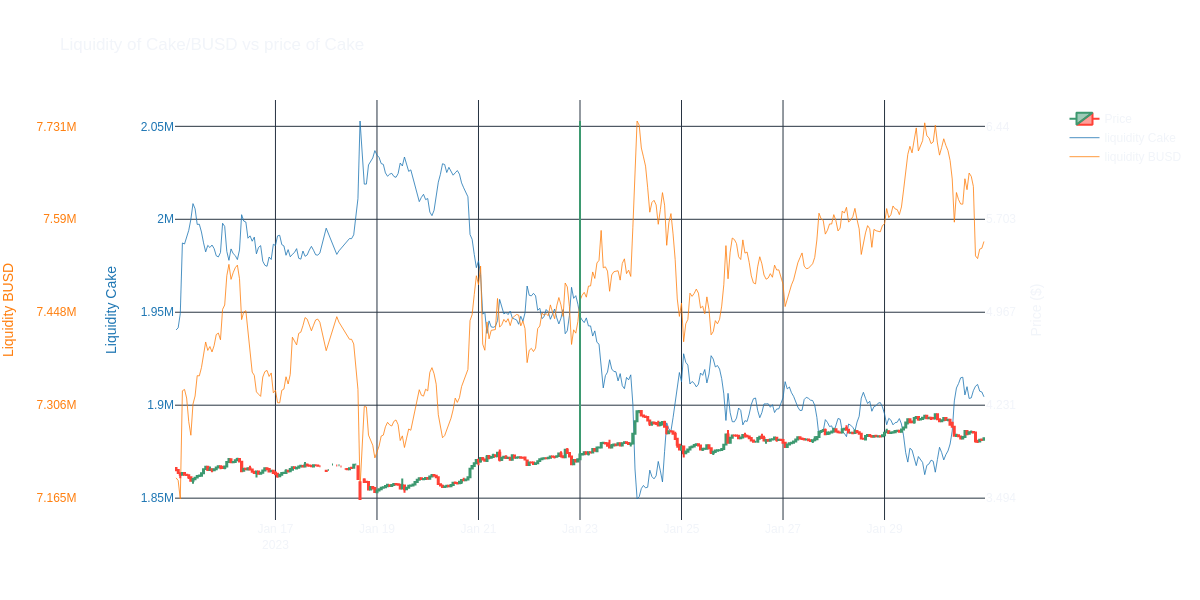

In [7]:
fig  = make_subplots()

candlestick = go.Candlestick(
    x=tohlcv_resp['time'],
    open=tohlcv_resp['open_stable'],
    high=tohlcv_resp['high_stable'],
    low=tohlcv_resp['low_stable'],
    close=tohlcv_resp['close_stable'],
    name="Price",
    yaxis="y3"
)

lq = go.Scatter(x=liquidity['time'],
                y=liquidity['liquidity0'],
                name="liquidity {token0}".format(token0=token['token0_symbol'][0]),
                mode='lines',
                line=dict(width=0.8, color="#1f77b4"),
                )
lq2 = go.Scatter(x=liquidity['time'],
                 y=liquidity['liquidity1'],
                 name="liquidity {token1}".format(token1=token['token1_symbol'][0]),
                 mode='lines',
                 line=dict(width=0.8, color="#ff7f0e"),
                 yaxis='y2'
                 )

fig.add_trace(candlestick)
fig.add_trace(lq)
fig.add_trace(lq2)

fig.update_layout(
    width=1200, height=600,
    title="Liquidity of {lp} vs price of {token}".format(lp=token["lp_symbol"][0], token=token["token0_symbol"][0]),
    xaxis_rangeslider_visible=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        title="Liquidity {token0}".format(token0=token['token0_symbol'][0]),
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        ),
        tickmode="sync",
    ),
    yaxis2=dict(
        title="Liquidity {token1}".format(token1=token['token1_symbol'][0]),
        titlefont=dict(
            color="#ff7f0e"
        ),
        tickfont=dict(
            color="#ff7f0e"
        ),
        anchor="free",
        overlaying="y",
        side="left",
        autoshift=True,
        shift=-30,
        tickmode="sync",
    ),
    yaxis3=dict(
        title="Price ($)",
        anchor="x",
        overlaying="y",
        side="right",
        tickmode="sync",
    ),
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=1.25
)
)


fig.show("png")